WRF QGPV mean calculation

Code appears to work for both given phi_prime and phi_prime on boundaries with zero for initial guess
4b (this code) now works on Neumann BC; 4c) reworking initial data for boundary conditions - based on version 5 of code

In [1]:
import numpy as np
from numpy import *
import matplotlib.pyplot as plt
import netCDF4
from netCDF4 import Dataset
from wrf import ALL_TIMES,tk, to_np, getvar, CoordPair, destagger, smooth2d, interplevel, vinterp, ll_to_xy, latlon_coords,get_cartopy
import time

In [2]:
wrfout_fname = 'march_2020_wrfout.nc'  # trajectory output
#wrfout_fname = 'wrfout.nc'
wrfout = Dataset(wrfout_fname, 'r')  # Dataset is the class behavior to open the file

In [3]:
msfm = wrfout.variables['MAPFAC_M'][0, :, :]     # Map scale factor on mass grid
cor = wrfout.variables['F'][0,:, :]     # Coriolis parameter
ds = 1./wrfout.variables['RDX'][0]     # grid spacing SAME IN ZONAL AND MERIDIONAL DIRECTIONS
from wrf import smooth2d,extract_times
ti = 0
# Get the latitude and longitude points# Get the sea level pressure
slp = getvar(wrfout, "slp", timeidx=ti)
lats, lons = latlon_coords(slp)
jlen = slp.shape[0]
ilen = slp.shape[1]
for j in range(jlen):
    for i in range(ilen):
        if lons[j,i] < 0.0:
            lons[j,i] = lons[j,i] + 360.
        else:
            lons[j,i] = lons[j,i]
# Get the cartopy mapping object
cart_proj = get_cartopy(slp)

In [4]:
from standard_atmosphere import standard_atmosphere
pb = 1000.
pb_half = 975.
pt = 100.
pt_half = 125.
p_levels = np.linspace(pb,pt,19)
p_half_levels = np.linspace(pb_half,pt_half,18)

ZS,phiS,TS,SS=standard_atmosphere(p_levels, p_half_levels)

In [5]:
# Geopotential height

num_lats=lats.shape[0]
num_lons=lons.shape[1]
num_levs=p_levels.size
z = getvar(wrfout, "z", units="m", timeidx=ALL_TIMES)

num_times=z.shape[0]

z_full=np.zeros([num_times,num_levs,num_lats,num_lons])
for time in np.arange(num_times):
    z_full[time,:] = vinterp(wrfout, z[time,:], 'pressure', p_levels, extrapolate=True, field_type='z', log_p=True, timeidx=time,meta=False)

In [6]:
z_mean = np.average(z_full,axis=0)

In [7]:
from geovort import geostrophic_vorticity

num_lats=lats.shape[0]
num_lons=lons.shape[1]
num_levs=p_levels.size

g=9.81

f0 = np.average(cor)
phi_prime=np.zeros([p_levels.size,num_lats,num_lons])

for k in np.arange(p_levels.size):
    phi_prime[k,:]=g*(z_mean[k,:]-ZS[k])
    
qgpv_geovor=geostrophic_vorticity(num_levs,num_lats,num_lons,msfm,ds,f0,phi_prime)

In [8]:
def stretching_term(num_levs,num_lats,num_lons,msfm,ds,dp,f0,S,phip):

    AC_3s=np.zeros([num_levs])
    AC_6=np.zeros([num_levs])
    AC_7=np.zeros([num_levs]) 
    
    for k in np.arange(1,18):
        AC_6[k]=f0/(S[k-1]*dp**2.)
        AC_7[k]=f0/(S[k]  *dp**2.)
        AC_3s[k]= -(AC_6[k]+AC_7[k])
    strat=np.zeros([num_levs,num_lats,num_lons])
    
    for k in np.arange(1,num_levs-1):
        for j in np.arange(1,num_lats-1):
            for i in np.arange(1,num_lons-1):
                strat[k,j,i] = AC_3s[k]*phip[k,j,i]+ AC_6[k]*phip[k-1,j,i]+ AC_7[k]*phip[k+1,j,i]
    return strat

In [9]:
dp = 50.e2


T_prime=np.zeros([p_levels.size,num_lats,num_lons])
z_prime=np.zeros([p_levels.size,num_lats,num_lons])

Tb=np.zeros([num_lats,num_lons])
Tt=np.zeros([num_lats,num_lons])

dz_b=np.zeros([num_lats,num_lons])
dz_t=np.zeros([num_lats,num_lons])

R=287.04
p=p_levels


for k in range(p_levels.size):
    z_prime[k,:] = z_mean[k,:]-ZS[k]

dz_b = z_prime[1,:]-z_prime[0,:]
dz_t = z_prime[-1,:]-z_prime[-2,:]

Tb = ((g*dz_b)/R)/np.log(p[0]/p[1])
Tt = ((g*dz_t)/R)/np.log(p[-2]/p[-1])


In [10]:
qgpv_strtch = stretching_term(num_levs,num_lats,num_lons,msfm,ds,dp,f0,SS,phi_prime)
qgpv = qgpv_geovor + qgpv_strtch

In [11]:
%%time

from qgpv_invert import qgpv_invert

iterations=600
threshold = 2.5
omega = 1.8

BC =np.zeros([p_levels.size,num_lats,num_lons])
res=np.zeros([p_levels.size,num_lats,num_lons])

for k in range(1,p_levels.size-1):
    BC[k,:]=9.81*(z_prime[k,:])
BC_flag=0

for k in np.arange(1,num_levs-1):
    for j in np.arange(1,num_lats-1):
        for i in np.arange(1,num_lons-1):
            BC[k,j,i] = 0.0



phip=np.zeros([p_levels.size,num_lats,num_lons])
phip,res,num_iter=qgpv_invert(omega,iterations,threshold,p_levels,num_levs,num_lats,num_lons,f0, ds, dp,msfm,SS,qgpv, Tb, Tt, BC, BC_flag)

stopping at iteration number:  237
error, num_levs*num_lats*num_lons:  237 567853
CPU times: user 17min 55s, sys: 4.14 s, total: 17min 59s
Wall time: 17min 59s


In [12]:
print("Number of iterations: ", num_iter+1)
print("Average residual: ", np.mean(res))  
print("Absolute maximum residual: ", np.amax(res))

Number of iterations:  238
Average residual:  -0.3023199840997094
Absolute maximum residual:  2.4869276071137634


/Users/mcmorgan/miniconda3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


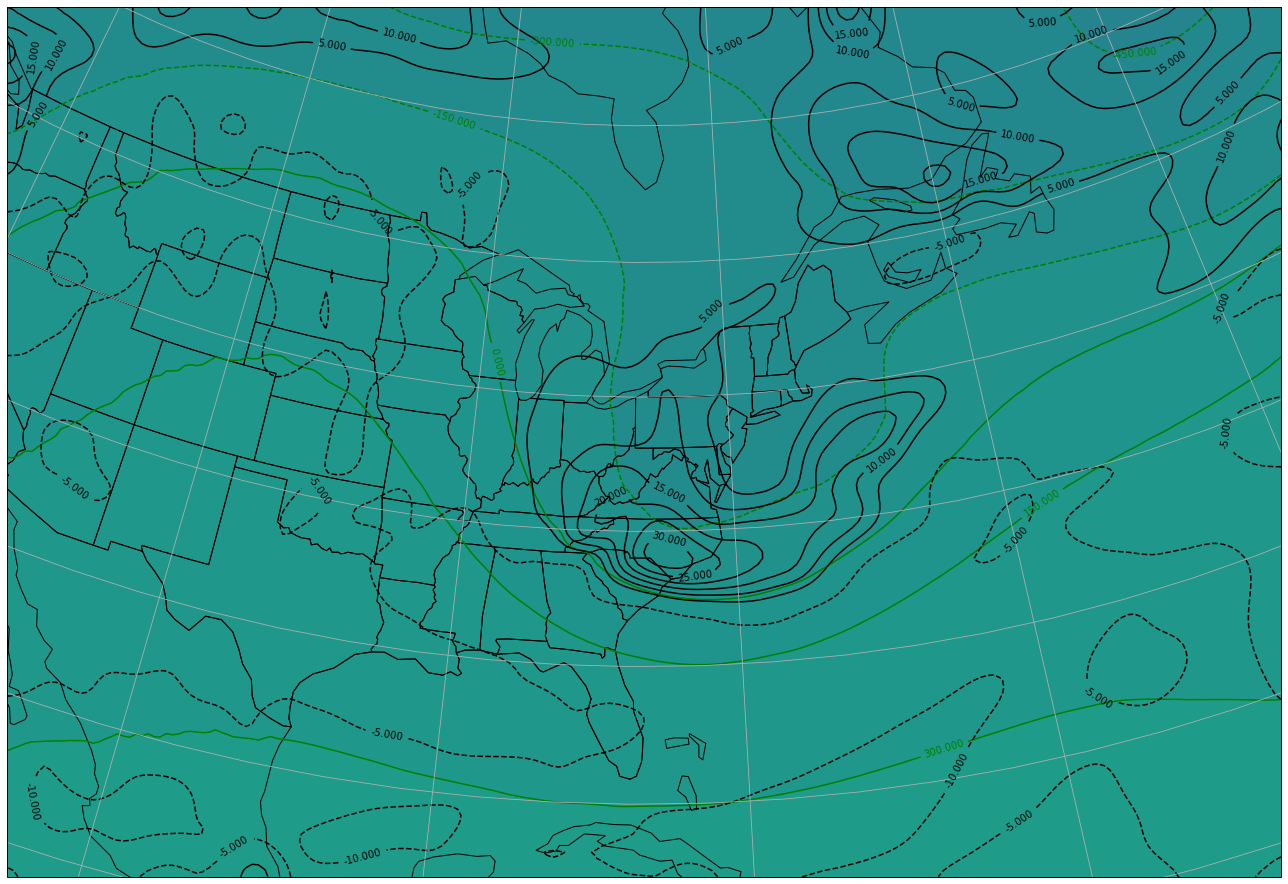

In [13]:
###%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter


ilev = 10
fig = plt.figure(figsize=(24, 16))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal())
# Set the GeoAxes to the projection used by WRF
ax = plt.axes(projection=cart_proj)

PHI = np.zeros([p_levels.size,num_lats,num_lons])
for k in np.arange(0,num_levs):
    PHI[k,:]=g*(to_np(z_mean[k,:])-ZS[k]) 
PHI[0,:] = PHI[1,:] - (R * Tb[:]/(100*p_levels[0]))*dp
PHI[-1,:] = PHI[-2,:] + (R * Tt[:]/(100.*p_levels[-1]))*dp

ax.contourf(lons, lats,PHI[ilev,:]/g, levels = np.arange(-4800,4800,150),transform=ccrs.PlateCarree())
CSz=ax.contour(lons, lats,PHI[ilev,:]/g, levels = np.arange(-450,525,150),transform=ccrs.PlateCarree(),colors='green')
#ax.contour(lons, lats,PHI[10,:]-phip[10,:],transform=ccrs.PlateCarree(),colors='grey')

#CS = ax.contour(lons, lats,res[10,:],transform=ccrs.PlateCarree(),colors='blue')
levels = np.arange(-150,155,5)

CS=ax.contour(lons,lats,gaussian_filter(qgpv[ilev,:]*1.e5, 3),colors='black',levels=levels[(levels < -0.01)|(levels>0.01)],transform=ccrs.PlateCarree())




ax.clabel(CS, CS.levels, inline=True,  fontsize=10)
ax.clabel(CSz, CSz.levels, inline=True,  fontsize=10)

# add some common geographic features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, edgecolor='black')
ax.add_feature(cfeature.BORDERS)

# add some lat/lon gridlines
ax.gridlines()



In [14]:
np.savez('mean_qgpv',qgpv=qgpv,geovor=qgpv_geovor)
np.savez('mean_hght',data=z_prime)

In [15]:
q=np.load('mean_qgpv.npz')
q.files

['qgpv', 'geovor']

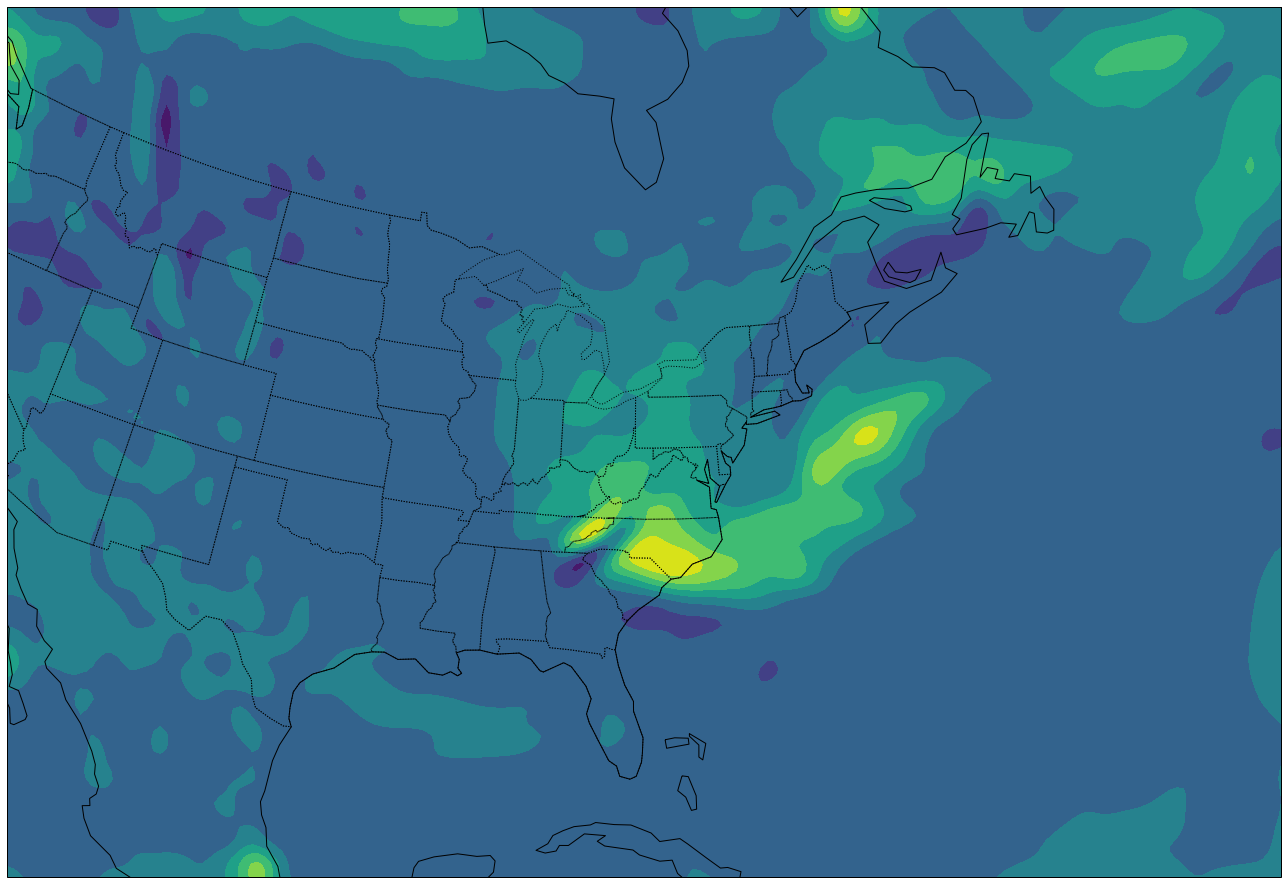

In [16]:
%matplotlib inline
from scipy.ndimage.filters import gaussian_filter

ilev=10
fig = plt.figure(figsize=(24, 16))
# Set the GeoAxes to the projection used by WRF
ax = plt.axes(projection=cart_proj)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS,linestyle=':')
ax.add_feature(cfeature.STATES,linestyle=':')

CS=ax.contourf(lons,lats,gaussian_filter(qgpv_geovor[ilev,:]*1.e4, 2),transform=ccrs.PlateCarree())
#CS_slp=ax.contour(lons, lats,slp,transform=ccrs.PlateCarree(),colors='grey')
#ax.contourf(lons,lats,Tb,cmap='RdBu_r',transform=ccrs.PlateCarree())

#ax.clabel(CS, CS.levels, inline=True,  fontsize=10,fmt='%.0f')
#ax.clabel(CS_slp, CS_slp.levels, inline=True,  fontsize=10,fmt='%.0f')


#calculate winds
U= np.zeros([num_lats,num_lons])
V=np.zeros([num_lats,num_lons])


SCALE = .025
for j in np.arange(1,num_lats-1):
    U[j,:] = -msfm[j,:]*0.5*(phip[ilev,j+1,:]-phip[ilev,j-1,:])/(f0*ds)

for i in np.arange(1,num_lons-1):
    V[:,i] =  msfm[:,i]*0.5*(phip[ilev,:,i+1]-phip[ilev,:,i-1])/(f0*ds)


quiver_slices = (slice(None, None, 7), slice(None, None, 7))
quiver_kwargs = {'headlength': 4, 'headwidth': 3,
                 'scale': 100}
#ax.set_extent([-160,-115,30,55])
#ax.quiver(to_np(lons[quiver_slices]),to_np(lats[quiver_slices]), \
#    U[::7,::7]*SCALE, V[::7,::7]*SCALE,color='blue',\
#    transform=ccrs.PlateCarree(),**quiver_kwargs)

plt.savefig('inversion_of_Tb_at_surface_for_time_F6')
plt.show()

In [17]:
f0.size

1